In [1]:
import sys
import argparse
import torch

sys.path.append('/home/ajliang/search/search')

from utils.common_utils import load_model
from map2map.map2map.data.fields import FieldDataset

"""Load Dataset"""
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

args = argparse.Namespace(
    init_input_path="/user_data/ajliang/Linear/val/LH0045/4/dis.npy",
    style_path="/user_data/ajliang/Linear/val/LH0045/4/params.npy",
    target_output_path="/user_data/ajliang/Nonlinear/val/LH0045/4/dis.npy",
    load_backward_model_state="/home/ajliang/search/model_weights/backward_model.pt",
    verbose=False,
    dropout_prob=0.0,
    crop=128
)

dataset = FieldDataset(
    style_pattern=args.style_path,
    in_patterns=[args.init_input_path],
    tgt_patterns=[args.target_output_path],
    in_norms=['cosmology.dis'],
    callback_at='/home/ajliang/search/search/map2map',
    crop=args.crop,
)

args.style_size = dataset.style_size
args.in_chan = dataset.in_chan
args.out_chan = dataset.tgt_chan
backward_model = load_model(args, device=device, path_to_model_state=args.load_backward_model_state)

target = dataset[len(dataset) // 2]['target']
target = target.unsqueeze(0) # add batch dimension
target = target.to(device)

input = dataset[len(dataset) // 2]['input']
input = input.unsqueeze(0) # add batch dimension
input = input.to(device)

style: torch.Tensor = dataset[len(dataset) // 2]['style']
style = style.unsqueeze(0) # add batch dimension
style = style.to(device)

# import pdb; pdb.set_trace()

# backward_model(target, style)

# style: torch.Tensor = dataset[len(dataset) // 2]['style']
# style = style.unsqueeze(0) # add batch dimension

# target: torch.Tensor = dataset[len(dataset) // 2]['target']
# target = target.unsqueeze(0) # add batch dimension

    # backward_model = load_model(args, device=device, path_to_model_state=args.load_backward_model_state)


/home/ajliang/anaconda3/envs/albert/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Loaded model from /home/ajliang/search/model_weights/backward_model.pt, which was trained for 128 epochs.


torch.Size([1, 3, 128, 128, 128])

In [2]:
import numpy as np

padded_target = np.pad(target, ((0, 0), (0, 0), (48, 48), (48, 48), (48, 48)), mode='wrap')
padded_target = torch.Tensor(padded_target)

In [11]:
import torch.nn.functional as F

padded_target = F.pad(target, (48, 48, 48, 48, 48, 48), mode='circular')

In [12]:
predicted_input = backward_model(padded_target, style)

In [14]:
padded_target.shape

torch.Size([1, 3, 224, 224, 224])

In [17]:
input.shape

torch.Size([1, 3, 128, 128, 128])

In [9]:
predicted_input.shape == torch.Size([1, 3, 40, 40, 40])

True

In [16]:
import Pk_library as PKL
import matplotlib.pyplot as plt
%matplotlib inline

def plot_ps_trans_stoc(input, true_input):
    # Setup for plotting power spectrums
    axis = 2
    
    input = input.squeeze(0) # remove batch dimension
    input = input.detach().numpy() # convert to numpy
    true_input = true_input.squeeze(0) # remove batch dimension
    true_input = true_input.detach().numpy() # convert to numpy

    # compute the auto power spectrum of input and true_input and the their cross power spectrum
    xpk = PKL.XPk(
        (input[axis], true_input[axis]),
        BoxSize=1e3/512 * 128,
        axis=0,
        MAS=(None, None)
    )
    wave_num = xpk.k3D
    
    input_power_spec = xpk.Pk[:, 0, 0]
    true_input_power_spec = xpk.Pk[:, 0, 1]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    # plot power spectrum of input and true_input
    ax1.loglog(wave_num, input_power_spec,
            color="orange", label="Learned Linear Input")
    ax1.loglog(wave_num, true_input_power_spec,
            color="blue", label="True Linear Input")
    ax1.set_xlabel("k (log scale)")
    ax1.set_ylabel("P(k) (log scale)")
    ax1.legend()
    ax1.set_title("Power vs Wave Number")

    # plot transfer function fractional errors between input and true_input
    tf_error = np.sqrt(input_power_spec / true_input_power_spec) - 1 # fractional error in transfer function
    ax2.semilogx(wave_num, tf_error, color="red")
    ax2.set_xlabel('k')
    ax2.set_ylabel('Transfer function fractional errors')
    ax2.set_title('Transfer function fractional errors vs k')

    # plot stochasticity
    cross = xpk.XPk[:, 0][:, 0] # cross power spectrum
    stoc = 1 - (cross / np.sqrt(input_power_spec * true_input_power_spec))**2 # stochasticity
    ax3.semilogx(wave_num, stoc, color="green")
    ax3.set_xlabel('k')
    ax3.set_ylabel('1 - (r(k)^2)')
    ax3.set_title('Stochasticty vs k')

    fig.tight_layout()
    plt.show()


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds


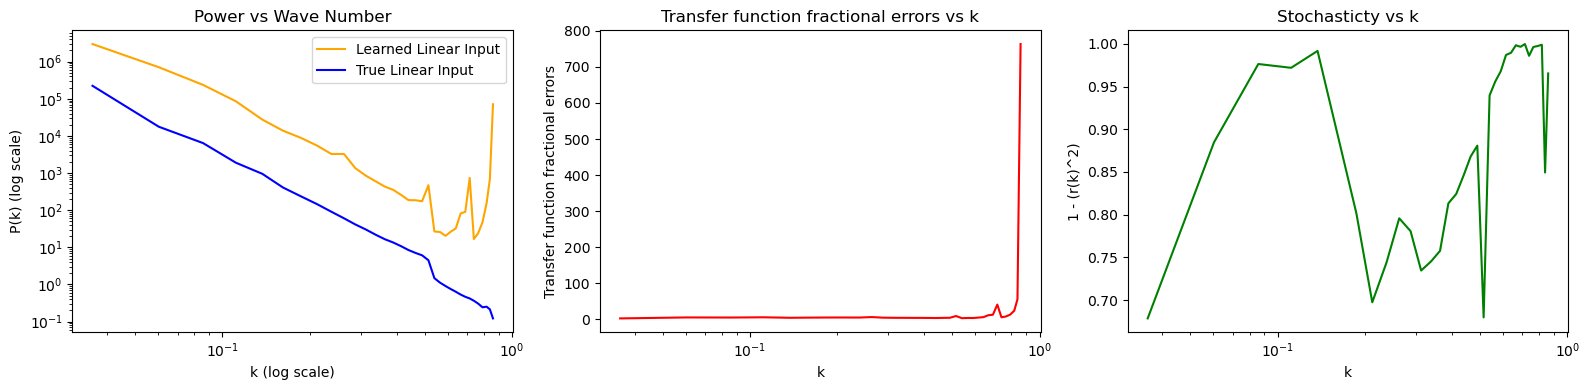

In [5]:
plot_ps_trans_stoc(predicted_input, input)


Computing power spectra of the fields...
Time FFTS = 0.04
Time loop = 0.08
Time taken = 0.13 seconds


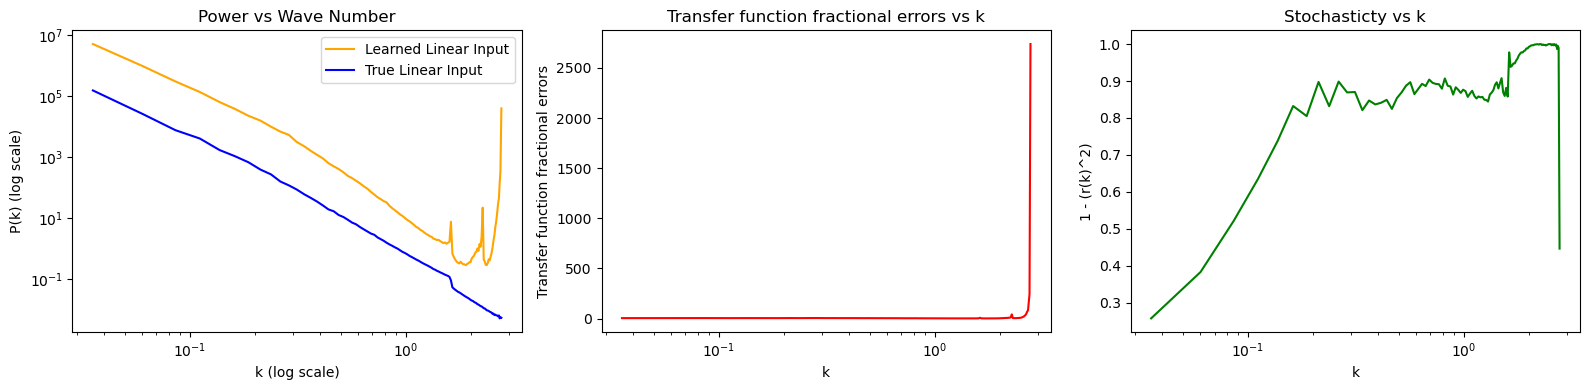

In [19]:
import numpy as np
plot_ps_trans_stoc(predicted_input, input)

In [25]:
predicted_input.shape

torch.Size([1, 3, 40, 40, 40])

In [26]:
predicted_input[2]

IndexError: index 2 is out of bounds for dimension 0 with size 1

In [37]:
arr1 = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
arr1 = arr1.unsqueeze(0) # add batch dimension
arr1 = arr1.unsqueeze(0) # add channel dimension
arr1

tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])

In [40]:
F.pad(arr1, (2, 2, 2, 2), mode='circular')

tensor([[[[5., 6., 4., 5., 6., 4., 5.],
          [8., 9., 7., 8., 9., 7., 8.],
          [2., 3., 1., 2., 3., 1., 2.],
          [5., 6., 4., 5., 6., 4., 5.],
          [8., 9., 7., 8., 9., 7., 8.],
          [2., 3., 1., 2., 3., 1., 2.],
          [5., 6., 4., 5., 6., 4., 5.]]]])

In [16]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

arr1 = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
arr1

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]])

In [18]:
np.pad(arr1, pad_width=((4, 4), (4, 4), (4, 4)), mode='wrap')

array([[[9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1]],

       [[9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1]],

       [[9, 7, 8, 9, 7, 8, 9, 7, 8, 9, 7],
       

In [13]:
np.pad(arr1, pad_width=((2, 2), (2, 2), (2, 2)), mode='reflect')

array([[[9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1],
        [6, 5, 4, 5, 6, 5, 4],
        [9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1]],

       [[9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1],
        [6, 5, 4, 5, 6, 5, 4],
        [9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1]],

       [[9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1],
        [6, 5, 4, 5, 6, 5, 4],
        [9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1]],

       [[9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1],
        [6, 5, 4, 5, 6, 5, 4],
        [9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1]],

       [[9, 8, 7, 8, 9, 8, 7],
        [6, 5, 4, 5, 6, 5, 4],
        [3, 2, 1, 2, 3, 2, 1],
        [6, 5, 4, 5, 6, 5, 4],
